### COT Index
Data source: [Disaggregated Futures-and-Options Combined Reports](https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalCompressed/index.htm)  
Prod_Merc_Positions_COT_Index does not include swap dealers.  
Speculators_Positions_COT_Index includes managed money, other reportable, and non-reportable.  
Adjusted for OI.  
Set roll period to how many years you want to look back.

In [33]:
from IPython.display import display
import pandas as pd
import glob
import requests 

In [32]:
ROLL_PERIOD = '{days}D'.format(days=int(365.25 * 5))
CORN = 'CORN - CHICAGO BOARD OF TRADE'
COTTON = 'COTTON NO. 2 - ICE FUTURES U.S.'
WHEAT = 'WHEAT - CHICAGO BOARD OF TRADE'
WHEAT_KC = 'WHEAT - KANSAS CITY BOARD OF TRADE'
WHEAT_SRW = 'WHEAT-SRW - CHICAGO BOARD OF TRADE'
WHEAT_HRW = 'WHEAT-HRW - CHICAGO BOARD OF TRADE'
SOYBEANS = 'SOYBEANS - CHICAGO BOARD OF TRADE'
SOYBEAN_OIL = 'SOYBEAN OIL - CHICAGO BOARD OF TRADE'
SOYBEAN_MEAL = 'SOYBEAN MEAL - CHICAGO BOARD OF TRADE'

In [43]:
def download_cot(year, chunk_size=128):
    url = 'https://www.cftc.gov/files/dea/history/com_disagg_txt_{}.zip'.format(year)
    file_name = url.split('/')[-1]
    write_path = './data/' + file_name
    r = requests.get(url, stream=True)
    with open(write_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [3]:
def get_prod_merc_net_oi_adj(df):
    return (df.Prod_Merc_Positions_Long_All - df.Prod_Merc_Positions_Short_All) / df.Open_Interest_All * 100 # + (cot.Swap_Positions_Long_All - cot.Swap__Positions_Short_All)

In [4]:
def get_speculators_net_oi_adj(df):
    return ((df.M_Money_Positions_Long_All - df.M_Money_Positions_Short_All) + (df.Other_Rept_Positions_Long_All - df.Other_Rept_Positions_Short_All) + (df.NonRept_Positions_Long_All - df.NonRept_Positions_Short_All)) / df.Open_Interest_All * 100

In [5]:
def get_rolling_max(df, col_name, roll_period):
    return df[col_name].rolling(roll_period).max()

In [6]:
def get_rolling_min(df, col_name, roll_period):
    return df[col_name].rolling(roll_period).min()

In [15]:
def get_cot_index(df, name, roll_period):
    cot = df.query('Market_and_Exchange_Names == @name').copy(deep=True)
    cot = cot.set_index('report_date').sort_index()
    
    cot['Prod_Merc_Positions_Net'] = get_prod_merc_net_oi_adj(cot)
    cot['Speculators_Positions_Net'] = get_speculators_net_oi_adj(cot)
    cot['Prod_Merc_Positions_Net_Roll_Max'] = get_rolling_max(cot, 'Prod_Merc_Positions_Net', ROLL_PERIOD)
    cot['Prod_Merc_Positions_Net_Roll_Min'] = get_rolling_min(cot, 'Prod_Merc_Positions_Net', ROLL_PERIOD)
    cot['Speculators_Positions_Net_Roll_Max'] = get_rolling_max(cot, 'Speculators_Positions_Net', ROLL_PERIOD)
    cot['Speculators_Positions_Net_Roll_Min'] = get_rolling_min(cot, 'Speculators_Positions_Net', ROLL_PERIOD)
    
    # COT Index = (current value – minimal value) / (maximal value – minimal value) * 100
    cot['Prod_Merc_Positions_COT_Index'] = (cot.Prod_Merc_Positions_Net - cot.Prod_Merc_Positions_Net_Roll_Min) / (cot.Prod_Merc_Positions_Net_Roll_Max - cot.Prod_Merc_Positions_Net_Roll_Min) * 100
    cot['Speculators_Positions_COT_Index'] = (cot.Speculators_Positions_Net - cot.Speculators_Positions_Net_Roll_Min) / (cot.Speculators_Positions_Net_Roll_Max - cot.Speculators_Positions_Net_Roll_Min) * 100
    
    return cot

In [30]:
def display_cot(df):
    display(df[['Market_and_Exchange_Names', 'Speculators_Positions_COT_Index', 'Speculators_Positions_Net', 'Speculators_Positions_Net_Roll_Max', 'Speculators_Positions_Net_Roll_Min']].tail(8))
    display(df[['Market_and_Exchange_Names', 'Prod_Merc_Positions_COT_Index', 'Prod_Merc_Positions_Net', 'Prod_Merc_Positions_Net_Roll_Max', 'Prod_Merc_Positions_Net_Roll_Min']].tail(8))
    df.loc['2012-01-01':][['Speculators_Positions_COT_Index', 'Prod_Merc_Positions_COT_Index']].plot(figsize=(20,10));

In [ ]:
# Download latest report
download_cot(2021)

In [8]:
# Load Data
l = [pd.read_csv(filename, low_memory=False) for filename in glob.glob("./data/*.zip")]
df = pd.concat(l, axis=0)

In [9]:
# Format data
df['Market_and_Exchange_Names'] = df.Market_and_Exchange_Names.str.rstrip()
# 2011 & 2012 use Report_Date_as_MM_DD_YYYY.  All others use Report_Date_as_YYYY-MM-DD. Merge both into date.
df['report_date'] = pd.to_datetime(df['Report_Date_as_YYYY-MM-DD']).fillna(pd.to_datetime(df.Report_Date_as_MM_DD_YYYY))
df['publish_date'] = df.report_date + pd.DateOffset(days=3)

In [16]:
cot = get_cot_index(df, SOYBEANS, ROLL_PERIOD)

,Market_and_Exchange_Names,Speculators_Positions_COT_Index,Speculators_Positions_Net,Speculators_Positions_Net_Roll_Max,Speculators_Positions_Net_Roll_Min
report_date,,,,,
2021-02-02,SOYBEANS - CHICAGO BOARD OF TRADE,85.898397,15.782329,21.491596,-18.995053
2021-02-09,SOYBEANS - CHICAGO BOARD OF TRADE,88.973980,17.027530,21.491596,-18.995053
2021-02-16,SOYBEANS - CHICAGO BOARD OF TRADE,85.359607,15.564191,21.491596,-18.995053
2021-02-23,SOYBEANS - CHICAGO BOARD OF TRADE,90.308771,17.567942,21.491596,-18.995053
2021-03-02,SOYBEANS - CHICAGO BOARD OF TRADE,85.840054,15.758708,21.491596,-18.995053
2021-03-09,SOYBEANS - CHICAGO BOARD OF TRADE,85.651190,15.682243,21.491596,-18.995053
2021-03-16,SOYBEANS - CHICAGO BOARD OF TRADE,83.996101,15.012153,21.491596,-18.995053
2021-03-23,SOYBEANS - CHICAGO BOARD OF TRADE,84.939991,15.394303,21.491596,-18.995053


,Market_and_Exchange_Names,Prod_Merc_Positions_COT_Index,Prod_Merc_Positions_Net,Prod_Merc_Positions_Net_Roll_Max,Prod_Merc_Positions_Net_Roll_Min
report_date,,,,,
2021-02-02,SOYBEANS - CHICAGO BOARD OF TRADE,30.537532,-20.390259,9.054195,-33.334817
2021-02-09,SOYBEANS - CHICAGO BOARD OF TRADE,26.318160,-22.178809,9.054195,-33.334817
2021-02-16,SOYBEANS - CHICAGO BOARD OF TRADE,29.668848,-20.758486,9.054195,-33.334817
2021-02-23,SOYBEANS - CHICAGO BOARD OF TRADE,21.844598,-24.075108,9.054195,-33.334817
2021-03-02,SOYBEANS - CHICAGO BOARD OF TRADE,22.882670,-23.635079,9.054195,-33.334817
2021-03-09,SOYBEANS - CHICAGO BOARD OF TRADE,23.744864,-23.269604,9.054195,-33.334817
2021-03-16,SOYBEANS - CHICAGO BOARD OF TRADE,24.677403,-22.874310,9.054195,-33.334817
2021-03-23,SOYBEANS - CHICAGO BOARD OF TRADE,23.951033,-23.182211,9.054195,-33.334817


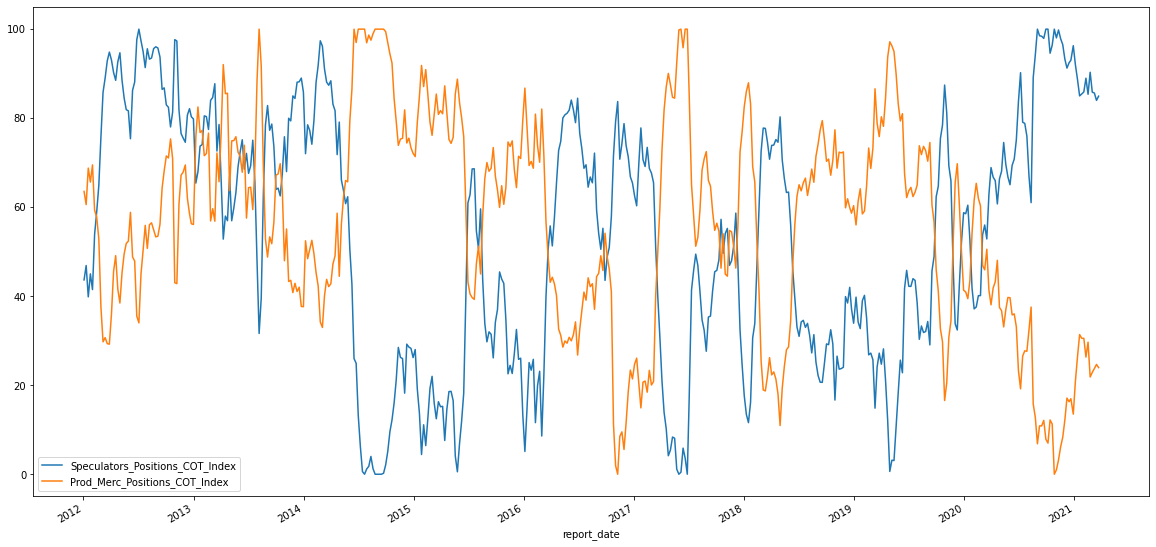

In [31]:
display_cot(cot)